##### <font size="50"><center> <font color='darkgreen'>Predicción (US, OS, RFECV, individualización lesiones)</font>

Partiendo del dataset creado tras el tratamiento de los datos de los chalecos GPS aportados por el Cádiz C.F, 
el presente documento realiza las siguientes acciones:
    
1. Exploración de nuestros datos, demostrar que las clases de nuestro conjunto de datos se hallan desbalanceadas
    
2. Aplicar técnicas de balanceo (Undersampling y Oversampling)
    
3. En ambos casos de balanceo (Undersampling y Oversampling), probar los siguientes clasificadores: LR, RF, DT, VM, MN
    
4. Entrenamiento de nuestro modelo utilizando la técnica de selección de atributos conocida como RFECV (rama superior)

5. Testeo con los atributos detectados mediante RFECV (rama inferior)

6. Individualización de lesiones
    
    




# Importaciones

In [1]:
# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Gestión de arrays y dataframes
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# Evitar warnings
import warnings

# Clasificadores 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


# herramientas para la clasificación / entrenamiento
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb

# Balanceadores de clases
from imblearn.over_sampling import ADASYN
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Métricas / Evaluadores
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import f1_score,confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, auc, f1_score

# Dibujo árbol de decisión
from sklearn import tree
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

# check version number
import imblearn
print(imblearn.__version__)

# Otros
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score


0.6.2


**Funciones auxiliares**

In [61]:
# Función para oversampling

def makeOverSamplesADASYN(X,y): 
    sm = ADASYN(sampling_strategy = 'minority')
    x_res, y_res = sm.fit_resample(X,y)
    return(x_res,y_res)

def tipo_result(a,b):
    
    if (a == b):
        if a == 1:
            return "Acierto / True Positive"
        else:
            return "Acierto / True Negative"
    
    if (a != b):
        if a == 1:
            return "Fallo / False Negative"
        else:
            return "Fallo / False Positive" 

**Importamos el dataset calculado** *dataset* conectando python a SQL y creamos un DF con una tabla 

In [68]:
import pandas as pd
import pymysql as my
##################################
# Abro Conexión
dbConnect = {
    'host':'localhost',
    'user':'root',
    'password':'1234',
    'database':'cadiz'
}

conexion = my.connect(**dbConnect)
cursor = conexion.cursor()
##################################

# CREO EL DATAFRAME Con la tabla PETOS
# - tabla anterior petos = pd.read_sql_query("SELECT * from petostfmcarga", conexion)
#petos = pd.read_sql_query("SELECT * from cadiz_db", conexion)
dataset = pd.read_sql_query("SELECT * from dataset", conexion)
dataset["Lesion"] = dataset["Lesion"].astype(int)
#petos = petos.fillna(0)
#petos.rename({"RPE_TST":"Carga"},axis =1, inplace = True)
#petos.sort_values("IdPeto", inplace = True)
#petos["PI_Acum"] = petos["PI_Acum"].astype(int)
#ps = pd.read_sql_query("SELECT * from petostfm_rpe", conexion)

data_player = pd.read_excel('Dataset_IdPlayer.xlsx')
data_player.drop(["Unnamed: 0"], axis=1, inplace=True)

## <font size="20"><center> <font color='blue'>1. Exploración de nuestros datos </font>

#### Verificar si hay nulos

In [4]:
dataset.isnull().values.any()

False

#### Dimensiones del dataset

In [5]:
dataset.shape

(2778, 52)

## Distribución de Clases

A continuación realizamos un análisis general de distribución de las clases de Lesión (1) y No Lesión (0) para entender en detalle la relación entre ellas.

Text(0, 0.5, 'Frecuencia')

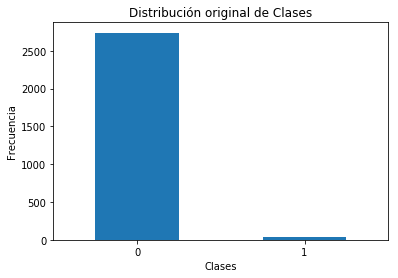

In [6]:
LABELS = ["0", "1"]
cont_clases = pd.value_counts(dataset["Lesion"], sort = True)
cont_clases.plot(kind ="bar", rot = 0)
plt.title("Distribución original de Clases")
plt.xticks(range(2),LABELS)
plt.xlabel("Clases")
plt.ylabel("Frecuencia")

In [7]:
## Verificamos la distribución numérica de Lesionados y No Lesionados
dataset.Lesion.value_counts()

0    2738
1      40
Name: Lesion, dtype: int64

## Conjunto de datos desbalanceado

Notamos que nuestro conjunto de datos se halla plenamente desbalanceado.

Contamos con 2738 registros de NO LESION (0) y simplemente 40 registros relacionados con una Lesión (1).

Resulta necesario aplicar técnicas de emparejamiento de clases, con el fin de evitar que nuestros clasificadores sean parciales a nuestra clase mayoritaria (0 - No Lesión)

## Correlacion básica entre variables

Realizamos un primer acercamiento a través del cáculo de correlaciones de nuestras variables en torno a la varible que queremos predecir: Lesión

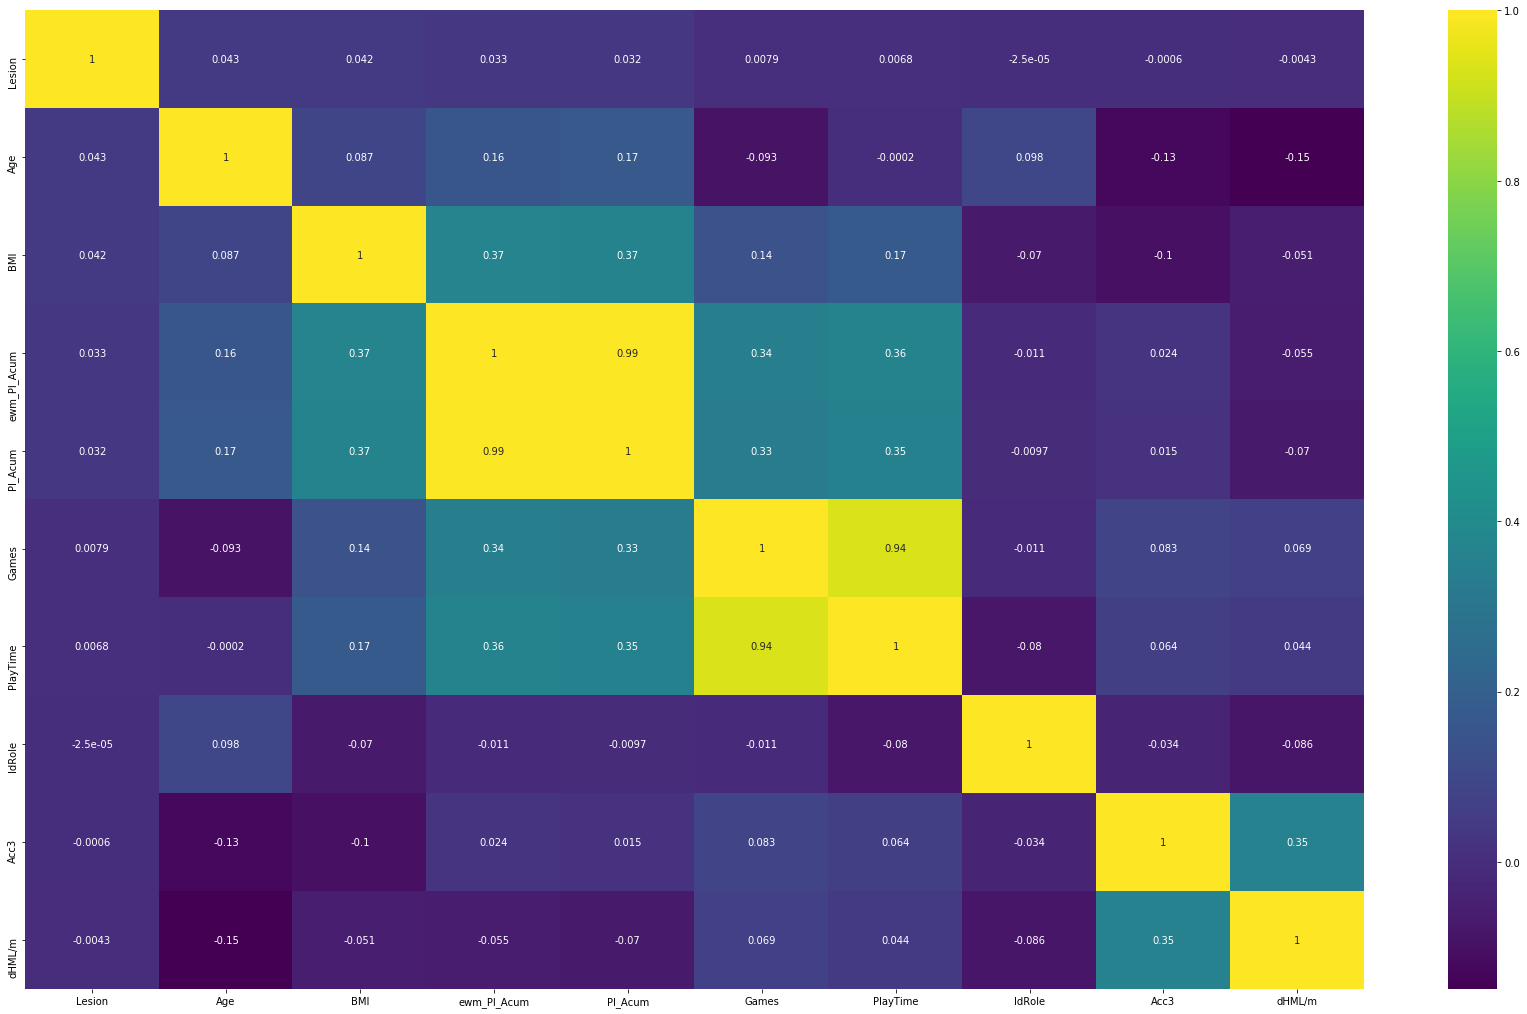

In [8]:
#Convertimos la columna Lesión a integer para poder trabajar con ella
dataset["Lesion"] = dataset["Lesion"].astype(int)
target = "Lesion"
numerical_feature_columns = list(dataset._get_numeric_data().columns)
k = 10 #number of variables for heatmap
cols = dataset[numerical_feature_columns].corr().nlargest(k, target)[target].index
cm = dataset[cols].corr()
plt.figure(figsize=(30,18))
sns.heatmap(cm, annot=True, cmap = 'viridis')

A priori podemos observar relaciones de Lesión con aspectos básicos físicos como Edad, BMI, y PI_Acum (lesiones previas)

## Creación grupos X, Y

En esta sección se lleva a cabo la divisón del dataset en 2 conjuntos:

1. Un conjunto (X) que contiene todas las columnas menos la etiqueta de Lesión

2. Un conjunto (Y) que sólo contiene la columna que representa al estado de Lesión (0:No lesión, 1:Lesión)

In [9]:
#X = dataset.loc[:, dataset.columns != target]
#Y = dataset.loc[:, dataset.columns == target]

# Diferenciamos las características dependientes de la dependiente

# creamos una lista con los nombres de las columnas de nuestro dataset
columns = dataset.columns.tolist()

# Creamos una lista con todas las columnas menos la de Lesión
columns = [c for c in columns if c not in ["Lesion"]]

# Guardamos la columna de Lesión por separado
target = "Lesion"

# definimos un random state
state = np.random.RandomState(42)
X = dataset[columns]
Y = dataset[target]
#X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

# Imprimimos las dimensiones de los nuevos dataframe de referencia
print(X.shape) # variables independientes
print(Y.shape) # etiqueta o variable dependiente

(2778, 51)
(2778,)


## <font size="20"><center> <font color='red'>2. Técnica de Undersampling (NearMiss)</font>
La técnica de Undersampling consiste en REDUCIR el número de los elementos de la clase mayoritaria (en este caso la clase representada por los 0s, o registros de NO LESIÓN), hasta igualar a la clase minoritaria (1)



In [10]:
## Trabajamos con la librería: imblearn.under_sampling import NearMiss
nm = NearMiss() # creamos el objeto de tipo NearMiss()
x_res, y_res = nm.fit_sample(X,Y) # aplicamos el undersampling
x_res.shape, y_res.shape # verificamos los tamaños


((80, 51), (80,))

Text(0, 0.5, 'Frecuencia')

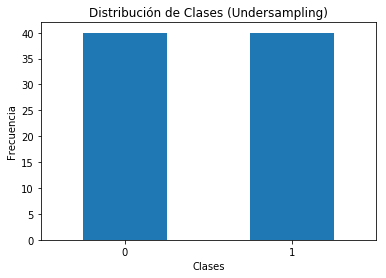

In [11]:
LABELS = ["0", "1"]
cont_clases = pd.value_counts(y_res, sort = True)
cont_clases.plot(kind ="bar", rot = 0)
plt.title("Distribución de Clases (Undersampling)")
plt.xticks(range(2),LABELS)
plt.xlabel("Clases")
plt.ylabel("Frecuencia")

In [12]:
# Utilizamos Counter para analizar la nueva distribución de clases
print('Distribución original sin undersampling {}'.format(Counter(Y)))
print('Distribución final con undersampling {}'.format(Counter(y_res)))

Distribución original sin undersampling Counter({0: 2738, 1: 40})
Distribución final con undersampling Counter({0: 40, 1: 40})


Como podemos apreciar, ahora tenemos tantos registros de 0 como de 1, contando con un dataset reducido y balanceado.

## División en conjuntos de Test y Train (UnderSampling)

In [13]:
# Con undersampling
x_trainUS, x_testUS, y_trainUS, y_testUS = train_test_split(x_res, y_res, 
                                                    test_size=0.2, 
                                                    random_state=8)

## Clasificadores con Undersampling

In [14]:
# Regresión logística US

warnings.filterwarnings("ignore")

clf_lr = LogisticRegression() 
clf_lr.fit(x_trainUS,y_trainUS)
predictionslr = clf_lr.predict(x_testUS)
print(classification_report(y_testUS,predictionslr))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.67      0.57      0.62         7

    accuracy                           0.69        16
   macro avg       0.68      0.67      0.68        16
weighted avg       0.69      0.69      0.68        16



In [15]:
# Random Forest US

rf = RandomForestClassifier()
rf.fit(x_trainUS,y_trainUS)
predictionsrf = rf.predict(x_testUS)
print(classification_report(y_testUS,predictionsrf))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.86      0.86      0.86         7

    accuracy                           0.88        16
   macro avg       0.87      0.87      0.87        16
weighted avg       0.88      0.88      0.88        16



In [16]:
# Vector Máquina US

warnings.filterwarnings("ignore")

svmc = SVC(kernel='rbf', C=1E6, gamma='auto')
svmc.fit(x_trainUS,y_trainUS)
predictionsSVM = svmc.predict(x_testUS)
print(classification_report(y_testUS,predictionsSVM))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.44      1.00      0.61         7

    accuracy                           0.44        16
   macro avg       0.22      0.50      0.30        16
weighted avg       0.19      0.44      0.27        16



In [17]:
# Decision Tree Classifier US

dtUS = tree.DecisionTreeClassifier()
dtUS.fit(x_trainUS,y_trainUS)
predictionsdtUS = dtUS.predict(x_testUS)
print(classification_report(y_testUS,predictionsdtUS))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.70      1.00      0.82         7

    accuracy                           0.81        16
   macro avg       0.85      0.83      0.81        16
weighted avg       0.87      0.81      0.81        16



In [18]:
## Binomial US
mn = MultinomialNB()
mn.fit(x_trainUS,y_trainUS)
predictionsMN = mn.predict(x_testUS)
print(classification_report(y_testUS,predictionsMN))

              precision    recall  f1-score   support

           0       0.62      0.89      0.73         9
           1       0.67      0.29      0.40         7

    accuracy                           0.62        16
   macro avg       0.64      0.59      0.56        16
weighted avg       0.64      0.62      0.58        16



## <font size="20"> <center> <font color='blue'>3. Técnica de Oversampling (ADASYN)</font>

En esta sección buscaremos balanecar nuestros datos utilizando técnicas de Oversampling.

En particular, estaremos creando ejemplos sintéticos de la clase minoritaria para así emparejarla con la clase mayoritaria

In [19]:
# Creamos nuevos conjuntos de train y test balanceados con oversampling
xAD,yAD = makeOverSamplesADASYN(X,Y)

# Utilizamos Counter para analizar la nueva distribución de clases
print('Distribución original sin undersampling {}'.format(Counter(Y)))
print('Distribución final con undersampling {}'.format(Counter(yAD)))


Distribución original sin undersampling Counter({0: 2738, 1: 40})
Distribución final con undersampling Counter({0: 2738, 1: 2730})


Notamos que logramos balancear las clases, aumentando los ejemplos de la clase minoritaria

Text(0, 0.5, 'Frecuencia')

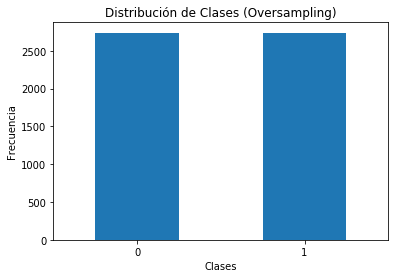

In [20]:
LABELS = ["0", "1"]
cont_clases = pd.value_counts(yAD, sort = True)
cont_clases.plot(kind ="bar", rot = 0)
plt.title("Distribución de Clases (Oversampling)")
plt.xticks(range(2),LABELS)
plt.xlabel("Clases")
plt.ylabel("Frecuencia")

## División en conjuntos de Test y Train (OverSampling)

In [21]:
x_trainAD, x_testAD, y_trainAD, y_testAD = train_test_split(xAD,yAD, 
                                                    test_size=0.2, 
                                                    random_state=8)

## Clasificadores con Oversampling

In [22]:
# Regresión logística Oversampling

clf_lrAD = LogisticRegression() 
clf_lrAD.fit(x_trainAD,y_trainAD)
predictionslrAD = clf_lrAD.predict(x_testAD)
print(classification_report(y_testAD,predictionslrAD))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65       575
           1       0.62      0.75      0.68       519

    accuracy                           0.66      1094
   macro avg       0.67      0.67      0.66      1094
weighted avg       0.67      0.66      0.66      1094



In [23]:
# Random Forest Oversampling

rfAD = RandomForestClassifier()
rfAD.fit(x_trainAD,y_trainAD)
predictionsrfAD = rfAD.predict(x_testAD)
print(classification_report(y_testAD,predictionsrfAD))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       575
           1       1.00      0.99      1.00       519

    accuracy                           1.00      1094
   macro avg       1.00      1.00      1.00      1094
weighted avg       1.00      1.00      1.00      1094



In [24]:
# Vector Máquina Oversampling

svmcAD = SVC(kernel='rbf', C=1E6, gamma='auto')
svmcAD.fit(x_trainAD,y_trainAD)
predictionsSVMAD = svmcAD.predict(x_testAD)
print(classification_report(y_testAD,predictionsSVMAD))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       575
           1       1.00      0.22      0.37       519

    accuracy                           0.63      1094
   macro avg       0.79      0.61      0.55      1094
weighted avg       0.78      0.63      0.56      1094



In [25]:
# Decision Tree Classifier Oversampling

dtAD = tree.DecisionTreeClassifier()
dtAD.fit(x_trainAD,y_trainAD)
predictionsdtAD = dtAD.predict(x_testAD)
print(classification_report(y_testAD,predictionsdtAD))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       575
           1       0.96      0.98      0.97       519

    accuracy                           0.97      1094
   macro avg       0.97      0.97      0.97      1094
weighted avg       0.97      0.97      0.97      1094



In [26]:
## Binomial Oversampling
mnAD = MultinomialNB()
mnAD.fit(x_trainAD,y_trainAD)
predictionsMNAD = mnAD.predict(x_testAD)
print(classification_report(y_testAD,predictionsMNAD))


              precision    recall  f1-score   support

           0       0.66      0.46      0.54       575
           1       0.55      0.73      0.63       519

    accuracy                           0.59      1094
   macro avg       0.61      0.60      0.59      1094
weighted avg       0.61      0.59      0.59      1094



## <font size="20"><center> <font color='darkblue'> 4. Rama superior (RFECV) </font>

El objetivo de esta sección utilizar el 30% de los datos del dataset Original (tras aplicar ADASYN), para aplicar RFECV con distintos clasificadores y detectar cuales son los atributos más importantes de nuestro dataset.

1. Aplicamos ADASYN sobre los dataframes originales.
2. Separamos en grupos de Train y Test con una proporción 30/70 respectivamente
3. Aplicamos RFECV con LR, RF, DT, VM, MN para detectar los atributos más relevantes


## Aplicación de ADASYN

In [27]:
# Creamos nuevos conjuntos de train y test balanceados con oversampling
xAd,yAd = makeOverSamplesADASYN(X,Y)

# Utilizamos Counter para analizar la nueva distribución de clases
print('Distribución original sin undersampling {}'.format(Counter(Y)))
print('Distribución final con undersampling {}'.format(Counter(yAd)))

Distribución original sin undersampling Counter({0: 2738, 1: 40})
Distribución final con undersampling Counter({0: 2738, 1: 2730})


## Train y Test (30 - 70)

In [28]:
x_trainA, x_testA, y_trainA, y_testA = train_test_split(xAd,yAd, 
                                                    test_size=0.7, 
                                                    random_state=8)

## RFECV con distintos clasificadores

Entrenaremos nuestro modelo utilizando distintos clasificadores: LR, MN, DT y RF

**Regresión logística**

In [29]:
# Clasificador regresión logistica

clf_lr = LogisticRegression()      
rfecvLR = RFECV(estimator=clf_lr, step=1, cv=2, scoring='accuracy')
rfecvLR = rfecvLR.fit(x_trainA, y_trainA)

warnings.filterwarnings("ignore")

print('Optimal number of features :', rfecvLR.n_features_)
print('Best features :', x_trainA.columns[rfecvLR.support_])
predictions_lrRFECV = rfecvLR.predict(x_testA)
print(classification_report(y_testA,predictions_lrRFECV))

Optimal number of features : 26
Best features : Index(['Acc3', 'Dec2', 'Dec3', 'Age', 'PI_Acum', 'Games', 'ewm_Acc2',
       'ewm_Dec2', 'ewm_Dec3', 'ewm_DSL', 'ac_dTOT', 'ac_dHSR', 'ac_dHML/m',
       'ac_Acc2', 'ac_Acc3', 'ac_Dec2', 'ac_Dec3', 'ac_FI', 'ms_dHSR',
       'ms_dMET', 'ms_dHML', 'ms_Acc2', 'ms_Acc3', 'ms_Dec2', 'ms_Dec3',
       'ms_DSL'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1915
           1       0.75      0.82      0.78      1913

    accuracy                           0.77      3828
   macro avg       0.77      0.77      0.77      3828
weighted avg       0.77      0.77      0.77      3828



**Bayesiano Binomial**

In [30]:
#Bayesiano Binomial

mn = MultinomialNB()
rfecvMN = RFECV(estimator=mn, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecvMN.fit(x_trainA, y_trainA)

print('Optimal number of features :', rfecvMN.n_features_)
print('Best features :', x_trainA.columns[rfecvMN.support_])
predictions_mnRFECV = rfecvMN.predict(x_testA)
print(classification_report(y_testA,predictions_mnRFECV))

Optimal number of features : 20
Best features : Index(['Dec3', 'ewm_Acc3', 'ewm_Dec3', 'ewm_PI_Acum', 'ac_dTOT', 'ac_dHSR',
       'ac_dMET', 'ac_dHML', 'ac_dHML/m', 'ac_Acc2', 'ac_Acc3', 'ac_Dec2',
       'ac_Dec3', 'ac_DSL', 'ac_FI', 'ms_Acc3', 'ms_Dec2', 'ms_Dec3', 'ms_DSL',
       'ms_FI'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      1915
           1       0.68      0.71      0.69      1913

    accuracy                           0.69      3828
   macro avg       0.69      0.69      0.69      3828
weighted avg       0.69      0.69      0.69      3828



**Clasificador Vector Máquina**

In [31]:
'''

svmc = SVC(kernel='linear', C=1E6, gamma='auto')
rfecvSVMC = RFECV (estimator=svmc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecvSVMC.fit(x_trainA, y_trainA)

print('Optimal number of features :', rfecvSVMC.n_features_)
print('Best features :', x_trainA.columns[rfecvSVMC.support_])
predictions_svmcRFECV = rfecvSVMC.predict(x_testA)
print(classification_report(y_testA,predictions_svmcRFECV))

'''

"\n\nsvmc = SVC(kernel='linear', C=1E6, gamma='auto')\nrfecvSVMC = RFECV (estimator=svmc, step=1, cv=StratifiedKFold(2), scoring='accuracy')\nrfecvSVMC.fit(x_trainA, y_trainA)\n\nprint('Optimal number of features :', rfecvSVMC.n_features_)\nprint('Best features :', x_trainA.columns[rfecvSVMC.support_])\npredictions_svmcRFECV = rfecvSVMC.predict(x_testA)\nprint(classification_report(y_testA,predictions_svmcRFECV))\n\n"

**Decision tree**

In [32]:
# Decision Tree (Rama Superior)

dtc = tree.DecisionTreeClassifier()
rfecvDT = RFECV(estimator=dtc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecvDT.fit(x_trainA, y_trainA)

print('Optimal number of features :', rfecvDT.n_features_)
print('Best features :', x_trainA.columns[rfecvDT.support_])
predictions_dtRFECV = rfecvDT.predict(x_testA)
print(classification_report(y_testA,predictions_dtRFECV))

Optimal number of features : 40
Best features : Index(['dMET', 'dHML', 'dHML/m', 'Acc2', 'Acc3', 'Dec2', 'Dec3', 'DSL', 'FI',
       'Age', 'BMI', 'IdRole', 'PI_Acum', 'Games', 'ewm_dTOT', 'ewm_dHSR',
       'ewm_dMET', 'ewm_dHML', 'ewm_dHML/m', 'ewm_Acc2', 'ewm_Acc3',
       'ewm_Dec2', 'ewm_Dec3', 'ewm_FI', 'ewm_PI_Acum', 'ac_dHSR', 'ac_dMET',
       'ac_dHML', 'ac_dHML/m', 'ac_Acc2', 'ac_Acc3', 'ac_Dec2', 'ac_Dec3',
       'ac_DSL', 'ac_FI', 'ms_dHSR', 'ms_dMET', 'ms_dHML', 'ms_dHML/m',
       'ms_Acc3'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1915
           1       0.94      0.94      0.94      1913

    accuracy                           0.94      3828
   macro avg       0.94      0.94      0.94      3828
weighted avg       0.94      0.94      0.94      3828



**Random Forest**

In [33]:
# Clasificador Random Forest

rfc = RandomForestClassifier(random_state=101)
rfecvRFC = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecvRFC.fit(x_trainA, y_trainA)

print('Optimal number of features :', rfecvRFC.n_features_)
print('Best features :', x_trainA.columns[rfecvRFC.support_])
predictions_rfcRFECV = rfecvRFC.predict(x_testA)
print(classification_report(y_testA,predictions_rfcRFECV))

Optimal number of features : 46
Best features : Index(['dTOT', 'dHSR', 'dMET', 'dHML', 'dHML/m', 'Acc2', 'Acc3', 'Dec2',
       'Dec3', 'FI', 'Age', 'BMI', 'IdRole', 'PI_Acum', 'PlayTime', 'Games',
       'ewm_dTOT', 'ewm_dHSR', 'ewm_dHML', 'ewm_Acc2', 'ewm_Acc3', 'ewm_Dec2',
       'ewm_Dec3', 'ewm_DSL', 'ewm_FI', 'ewm_PI_Acum', 'ac_dTOT', 'ac_dHSR',
       'ac_dMET', 'ac_dHML', 'ac_dHML/m', 'ac_Acc2', 'ac_Dec2', 'ac_Dec3',
       'ac_DSL', 'ac_FI', 'ms_dTOT', 'ms_dHSR', 'ms_dMET', 'ms_dHML',
       'ms_dHML/m', 'ms_Acc2', 'ms_Acc3', 'ms_Dec2', 'ms_Dec3', 'ms_DSL'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1915
           1       0.97      0.99      0.98      1913

    accuracy                           0.98      3828
   macro avg       0.98      0.98      0.98      3828
weighted avg       0.98      0.98      0.98      3828



## <font size="20"><center> <font color='darkblue'> 5. Rama inferior (Cross Validation)</font>

En esta sección trabajaremos sobre el 70% de los datos restantes, y con los atributos detectados mediante la aplicación de RFECV en la rama Superior

1. Crear rama inferior con los atributos detectados por RFECV 
2. Separar en nuevos conjuntos de Train y Test, pero ahora con la distribución 50/50
3. Entrenar los clasificadores LR, RF, DT, VM, MN con los atributos detectados por RFECV 

## Creación de rama inferior

In [34]:
# Usamos las columnas devueltas por REFCV con RFC en la sección anterior 
atributos = x_trainA.columns[rfecvRFC.support_].tolist()

rama_inferior = x_testA[atributos]

## Train y Test sobre el 70% (50 - 50) 

In [35]:
x_trainAB, x_testAB, y_trainAB, y_testAB = train_test_split(rama_inferior ,y_testA, 
                                                    test_size=0.5, 
                                                    random_state=8)

In [36]:
print('Distribución de y_trainAB {}'.format(Counter(y_trainAB)))
print('Distribución de y_testAB {}'.format(Counter(y_testAB)))

Distribución de y_trainAB Counter({0: 970, 1: 944})
Distribución de y_testAB Counter({1: 969, 0: 945})


## Clasificadores con las columnas de RFECV

En este apartado volvemos a aplicar los clasificadores que vimos anteriormente, pero utilizando un dataset que sólo considera los atributos más relevantes (obtenidos mediante RFECV)

**Decision tree**

In [37]:
# Decision Tree 

dtAB = tree.DecisionTreeClassifier(max_depth=4)
dtAB.fit(x_trainAB, y_trainAB)
predictionsdtAB = dtAB.predict(x_testAB)
print(classification_report(y_testAB,predictionsdtAB))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       945
           1       0.83      0.88      0.86       969

    accuracy                           0.85      1914
   macro avg       0.85      0.85      0.85      1914
weighted avg       0.85      0.85      0.85      1914



In [38]:
# En este punto extraems el arbol de decisión obtenido con el clasificador de Decision Tree
tree.export_graphviz(dtAB,
                     class_names = True,
                     feature_names = x_testAB.columns,
                     out_file="Arbol_finalDT.dot")

**Random Forest**

In [39]:
# Random Forest 

rfAB = RandomForestClassifier()
rfAB.fit(x_trainAB,y_trainAB)
predictionsrfAB = rfAB.predict(x_testAB)
print(classification_report(y_testAB,predictionsrfAB))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       945
           1       1.00      0.99      0.99       969

    accuracy                           0.99      1914
   macro avg       0.99      0.99      0.99      1914
weighted avg       0.99      0.99      0.99      1914



In [40]:
# En este punto extraems el arbol de decisión obtenido con el clasificador de Random Forest
estimators = rfAB.estimators_[5]
export_graphviz(estimators,
                     class_names = True,
                     feature_names = x_testAB.columns,
                     out_file="Arbol_finalRFC.dot")

**Regresión logística**

In [41]:
# Regresión logística 

clf_lrAB = LogisticRegression() 
clf_lrAB.fit(x_trainAB,y_trainAB)
predictionslrAB = clf_lrAB.predict(x_testAB)
print(classification_report(y_testAB,predictionslrAB))

              precision    recall  f1-score   support

           0       0.69      0.59      0.63       945
           1       0.65      0.74      0.69       969

    accuracy                           0.66      1914
   macro avg       0.67      0.66      0.66      1914
weighted avg       0.67      0.66      0.66      1914



**Vector Máquina**

In [42]:
# Vector Máquina 

svmcAB = SVC(kernel='rbf', C=1E6, gamma='auto')
svmcAB.fit(x_trainAB,y_trainAB)
predictionsSVMAB = svmcAB.predict(x_testAB)
print(classification_report(y_testAB,predictionsSVMAB))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       945
           1       1.00      0.10      0.18       969

    accuracy                           0.54      1914
   macro avg       0.76      0.55      0.43      1914
weighted avg       0.76      0.54      0.43      1914



**Bayesiano Binomial**

In [43]:
## Bayesiano Binomial 
mnAB = MultinomialNB()
mnAB.fit(x_trainAB,y_trainAB)
predictionsMNAB = mnAB.predict(x_testAB)
print(classification_report(y_testAB,predictionsMNAB))

              precision    recall  f1-score   support

           0       0.60      0.47      0.53       945
           1       0.57      0.70      0.63       969

    accuracy                           0.59      1914
   macro avg       0.59      0.58      0.58      1914
weighted avg       0.59      0.59      0.58      1914



## <font size="20"><center> <font color='darkblue'> 6. Individualización de lesiones </font>

El objetivo de este apartado es conocer de forma individual si cada uno de los jugadores se van a lesionar para la siguiente sesión. 

  1. El primer acercamiento es aplicar los algoritmos previamente entrenados en el apartado de Oversampling utilizando las columnas más importantes proporcionadas por RFECV. Los resultados obtenidos con esta técnica fueron 
  
  
  2. El segundo acercamiento consiste en entrenar de igual forma los mismos algoritmos pero con todas las columnas del dataset menos la columna Lesión (Y).

## Clasificadores con RFECV

**Decision tree**

In [44]:
#Se seleccionan solo los atributos de RF con RFECV
columnas_rfecvRFC = X[atributos]

In [45]:
#Decision tree
predictionsdt = dtAB.predict(columnas_rfecvRFC)

df = pd.DataFrame(Y)
df["prediccionDT"] = predictionsdt
df["ResultadoDT"] = np.where(df['Lesion'] == df['prediccionDT'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,prediccionDT,ResultadoDT,Conteo
0,0,0,True,2253
1,0,1,False,485
2,1,0,False,13
3,1,1,True,27


**Random Forest**

In [62]:
#Random Forest
predictionsrfAB = rfAB.predict(columnas_rfecvRFC)

df = pd.DataFrame(Y)
df["prediccionRF"] = predictionsrfAB
df["ResultadoRF"] = np.where(df['Lesion'] == df['prediccionRF'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,prediccionRF,ResultadoRF,Conteo
0,0,0,True,2728
1,0,1,False,10
2,1,0,False,9
3,1,1,True,31


**Regresión logística**

In [47]:
#Regresión Logísitca
predictionslr = clf_lrAB.predict(columnas_rfecvRFC)

df = pd.DataFrame(Y)
df["prediccionLR"] = predictionslr
df["ResultadoLR"] = np.where(df['Lesion'] == df['prediccionLR'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,prediccionLR,ResultadoLR,Conteo
0,0,0,True,1634
1,0,1,False,1104
2,1,0,False,14
3,1,1,True,26


**Vector máquina**

In [48]:
#Vector máquina
predictionsSVMAB = svmcAB.predict(columnas_rfecvRFC)

df = pd.DataFrame(Y)
df["prediccionSVMAB"] = predictionsSVMAB
df["ResultadoSVMAB"] = np.where(df['Lesion'] == df['prediccionSVMAB'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,prediccionSVMAB,ResultadoSVMAB,Conteo
0,0,0,True,2738
1,1,0,False,17
2,1,1,True,23


**Bayesiano Binomial**

In [49]:
#Bayesiano Binomial
predictionsMNAB = mnAB.predict(columnas_rfecvRFC)

df = pd.DataFrame(Y)
df["prediccionMNAB"] = predictionsMNAB
df["ResultadoMNAB"] = np.where(df['Lesion'] == df['prediccionMNAB'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,prediccionMNAB,ResultadoMNAB,Conteo
0,0,0,True,1287
1,0,1,False,1451
2,1,0,False,14
3,1,1,True,26


## Clasificadores sin RFECV

**Decision Tree**

In [63]:
#Decision tree
predictionsDT = dtAD.predict(X)

df = pd.DataFrame(Y)
df["predDT"] = predictionsDT
df["RtadoDT"] = np.where(df['Lesion'] == df['predDT'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,predDT,RtadoDT,Conteo
0,0,0,True,2715
1,0,1,False,23
2,1,0,False,3
3,1,1,True,37


**Random Forest**

In [65]:
#Random Forest
predictionsRF = rfAD.predict(X)


# Resumen de resultados de Random Forest
df = pd.DataFrame(Y)
df["Prediccion"] = predictionsRF
df["RtadoRF"] = df.apply(lambda x:tipo_result(x["Lesion"],x["Prediccion"]),axis = 1)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1).sort_values(by=['RtadoRF', 'Conteo'], ascending=[True, False])
#df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)
#df["RtadoRF"] = np.where(df['Lesion'] == df['predRF'],True,False)

,Lesion,Prediccion,RtadoRF,Conteo
0,0,0,Acierto / True Negative,2736
3,1,1,Acierto / True Positive,37
2,1,0,Fallo / False Negative,3
1,0,1,Fallo / False Positive,2


In [69]:
# Predicción visual Random Forest
lesionados = [df["Lesion"],df["Prediccion"], data_player["FullName"], df["RtadoRF"]]
headers = ["Lesion", "Prediccion","Nombre", "RtadoRF"]
df3 = pd. concat(lesionados, axis=1, keys=headers)

df3_res = df3[(df3.Lesion == 1) | (df3.Lesion == 0) & (df3.Prediccion == 1)]
df3_res.groupby(df3_res.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1).sort_values(by=['RtadoRF', 'Conteo'], ascending=[True, False])

,Lesion,Prediccion,Nombre,RtadoRF,Conteo
14,1,1,José Manuel Jurado Marín,Acierto / True Positive,6
19,1,1,Rafael Giménez Jarque,Acierto / True Positive,5
15,1,1,José María Martín-Bejarano Serrano,Acierto / True Positive,3
18,1,1,Marcos Mauro López Gutiérrez,Acierto / True Positive,3
6,1,1,Alexander Mesa Travieso,Acierto / True Positive,2
8,1,1,Eduardo Ramos Gómez,Acierto / True Positive,2
12,1,1,Jean-Pierre Rhyner,Acierto / True Positive,2
17,1,1,Luis Alfonso Espino García,Acierto / True Positive,2
20,1,1,Salvador Sánchez Ponce,Acierto / True Positive,2
21,1,1,Sergio Sánchez Ortega,Acierto / True Positive,2


**Regresión Logística**

In [52]:
#Regresión Logísitca
predictionsLR = clf_lrAD.predict(X)

df = pd.DataFrame(Y)
df["predLR"] = predictionsLR
df["RtadoLR"] = np.where(df['Lesion'] == df['predLR'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,predLR,RtadoLR,Conteo
0,0,0,True,1597
1,0,1,False,1141
2,1,0,False,13
3,1,1,True,27


**Vector máquina**

In [53]:
#Vector máquina
predictionsSVM = svmcAD.predict(X)

df = pd.DataFrame(Y)
df["predSVM"] = predictionsSVM
df["RtadoSVM"] = np.where(df['Lesion'] == df['predSVM'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,predSVM,RtadoSVM,Conteo
0,0,0,True,2738
1,1,0,False,1
2,1,1,True,39


**Bayesiano Binomial**

In [54]:
#Bayesiano Binomial
predictionsMN = mnAD.predict(X)

df = pd.DataFrame(Y)
df["predMN"] = predictionsMN
df["RtadoMN"] = np.where(df['Lesion'] == df['predMN'],True,False)
df.groupby(df.columns.tolist()).size().reset_index().rename({0: 'Conteo'}, axis=1)

,Lesion,predMN,RtadoMN,Conteo
0,0,0,True,1228
1,0,1,False,1510
2,1,0,False,12
3,1,1,True,28
